Setting up a new session...


batch: (512, 2)
-0.5318807363510132 -0.15888711810112
-0.5453814268112183 -0.24513846635818481
-0.3889927566051483 -0.35732460021972656
-0.2702997922897339 -0.38413625955581665
-0.29144495725631714 -0.41096529364585876
-0.19493234157562256 -0.5107800364494324
-0.17393578588962555 -0.5555019378662109
-0.091647669672966 -0.5686561465263367
-0.1074545830488205 -0.6624276638031006
-0.05762660503387451 -0.7005010843276978
-0.12702563405036926 -0.6622092723846436
-0.06840769946575165 -0.7431731820106506
-0.040193140506744385 -0.6196810007095337
-0.028676694259047508 -0.7024447917938232
-0.05148863047361374 -0.6650395393371582
-0.08048506081104279 -0.39625173807144165
-0.09066662192344666 -0.6619976758956909
-0.10407492518424988 -0.6153573393821716
-0.0820026621222496 -0.6165512800216675
0.0035147108137607574 -0.8213489651679993
-0.05698912590742111 -0.38286975026130676
-0.02652273327112198 -0.3922313451766968
-0.031360842287540436 -0.43453264236450195
-0.0456656739115715 -0.34491658210754395

KeyboardInterrupt: 

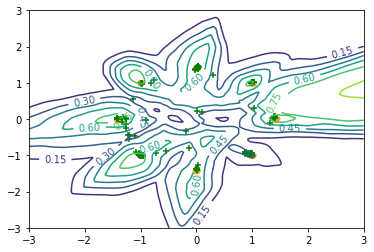

In [2]:
import  torch
from    torch import nn, optim, autograd
import  numpy as np
import  visdom
from    torch.nn import functional as F
from    matplotlib import pyplot as plt
import  random

h_dim = 400
batchsz = 512
viz = visdom.Visdom()

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 2),
        )

    def forward(self, z):
        output = self.net(z)
        return output


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.net(x)
        return output.view(-1)

def data_generator():

    scale = 2.
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1. / np.sqrt(2), 1. / np.sqrt(2)),
        (1. / np.sqrt(2), -1. / np.sqrt(2)),
        (-1. / np.sqrt(2), 1. / np.sqrt(2)),
        (-1. / np.sqrt(2), -1. / np.sqrt(2))
    ]
    centers = [(scale * x, scale * y) for x, y in centers]
    while True:
        dataset = []
        for i in range(batchsz):
            point = np.random.randn(2) * .02
            center = random.choice(centers)
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype='float32')
        dataset /= 1.414  # stdev
        yield dataset

    # for i in range(100000//25):
    #     for x in range(-2, 3):
    #         for y in range(-2, 3):
    #             point = np.random.randn(2).astype(np.float32) * 0.05
    #             point[0] += 2 * x
    #             point[1] += 2 * y
    #             dataset.append(point)
    #
    # dataset = np.array(dataset)
    # print('dataset:', dataset.shape)
    # viz.scatter(dataset, win='dataset', opts=dict(title='dataset', webgl=True))
    #
    # while True:
    #     np.random.shuffle(dataset)
    #
    #     for i in range(len(dataset)//batchsz):
    #         yield dataset[i*batchsz : (i+1)*batchsz]


def generate_image(D, G, xr, epoch):
    """
    Generates and saves a plot of the true distribution, the generator, and the
    critic.
    """
    N_POINTS = 128
    RANGE = 3
    plt.clf()

    points = np.zeros((N_POINTS, N_POINTS, 2), dtype='float32')
    points[:, :, 0] = np.linspace(-RANGE, RANGE, N_POINTS)[:, None]
    points[:, :, 1] = np.linspace(-RANGE, RANGE, N_POINTS)[None, :]
    points = points.reshape((-1, 2))
    # (16384, 2)
    # print('p:', points.shape)

    # draw contour
    with torch.no_grad():
        points = torch.Tensor(points).cuda() # [16384, 2]
        disc_map = D(points).cpu().numpy() # [16384]
    x = y = np.linspace(-RANGE, RANGE, N_POINTS)
    cs = plt.contour(x, y, disc_map.reshape((len(x), len(y))).transpose())
    plt.clabel(cs, inline=1, fontsize=10)
    # plt.colorbar()


    # draw samples
    with torch.no_grad():
        z = torch.randn(batchsz, 2).cuda() # [b, 2]
        samples = G(z).cpu().numpy() # [b, 2]
    xr = xr.cpu().numpy()
    plt.scatter(xr[:, 0], xr[:, 1], c='orange', marker='.')
    plt.scatter(samples[:, 0], samples[:, 1], c='green', marker='+')

    viz.matplot(plt, win='contour', opts=dict(title='p(x):%d'%epoch))


def weights_init(m):
    if isinstance(m, nn.Linear):
        # m.weight.data.normal_(0.0, 0.02)
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

def gradient_penalty(D, xr, xf):
    """

    :param D:
    :param xr:
    :param xf:
    :return:
    """
    LAMBDA = 0.3

    # only constrait for Discriminator
    xf = xf.detach()
    xr = xr.detach()

    # [b, 1] => [b, 2]
    alpha = torch.rand(batchsz, 1).cuda()
    alpha = alpha.expand_as(xr)

    interpolates = alpha * xr + ((1 - alpha) * xf)
    interpolates.requires_grad_()

    disc_interpolates = D(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones_like(disc_interpolates),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA

    return gp

def main():

    torch.manual_seed(23)
    np.random.seed(23)

    G = Generator().cuda()
    D = Discriminator().cuda()
    G.apply(weights_init)
    D.apply(weights_init)

    optim_G = optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.9))
    optim_D = optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.9))


    data_iter = data_generator()
    print('batch:', next(data_iter).shape)

    viz.line([[0,0]], [0], win='loss', opts=dict(title='loss',
                                                 legend=['D', 'G']))

    for epoch in range(50000):

        # 1. train discriminator for k steps
        for _ in range(5):
            x = next(data_iter)
            xr = torch.from_numpy(x).cuda()

            # [b]
            predr = (D(xr))
            # max log(lossr)
            lossr = - (predr.mean())

            # [b, 2]
            z = torch.randn(batchsz, 2).cuda()
            # stop gradient on G
            # [b, 2]
            xf = G(z).detach()
            # [b]
            predf = (D(xf))
            # min predf
            lossf = (predf.mean())

            # gradient penalty
            gp = gradient_penalty(D, xr, xf)

            loss_D = lossr + lossf + gp
            optim_D.zero_grad()
            loss_D.backward()
            # for p in D.parameters():
            #     print(p.grad.norm())
            optim_D.step()


        # 2. train Generator
        z = torch.randn(batchsz, 2).cuda()
        xf = G(z)
        predf = (D(xf))
        # max predf
        loss_G = - (predf.mean())
        optim_G.zero_grad()
        loss_G.backward()
        optim_G.step()


        if epoch % 100 == 0:
            viz.line([[loss_D.item(), loss_G.item()]], [epoch], win='loss', update='append')

            generate_image(D, G, xr, epoch)

            print(loss_D.item(), loss_G.item())






if __name__ == '__main__':
    main()